## This notebook is an exploration of the Kaggle Facial Keypoints Recognition Challenge this workbook follows a method recommended by Peter Skvarenina

### This work is done as preliminary exploration for UT Bootcamp Team EPIC Project 3 this workbook is the second of two and uses a more complex modeling method

In [37]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.layers import Dropout, Flatten

In [38]:
facesDF = pd.read_csv('data/training.csv')

In [39]:
facesDF.shape

(7049, 31)

In [40]:
def string2array(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(facesDF.index, size=(nrows*ncols), replace=False)
    image_strings = facesDF.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2array(string), cmap='gray')
        ax.axis('off')

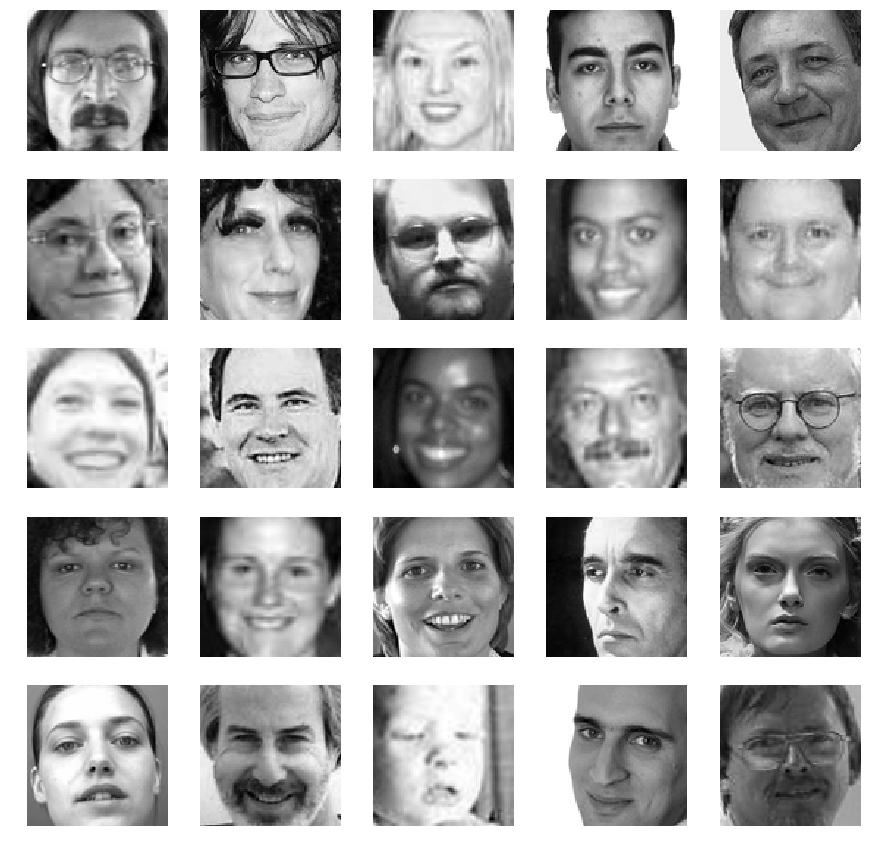

In [7]:
plot_faces()

In [41]:

def plot_faces_with_keypoints(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(facesDF.index, size=(nrows*ncols), replace=False)
    image_strings = facesDF.loc[selection]['Image']
    keypoint_cols = list(facesDF.columns)[:-1]
    keypoints = facesDF.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2array(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

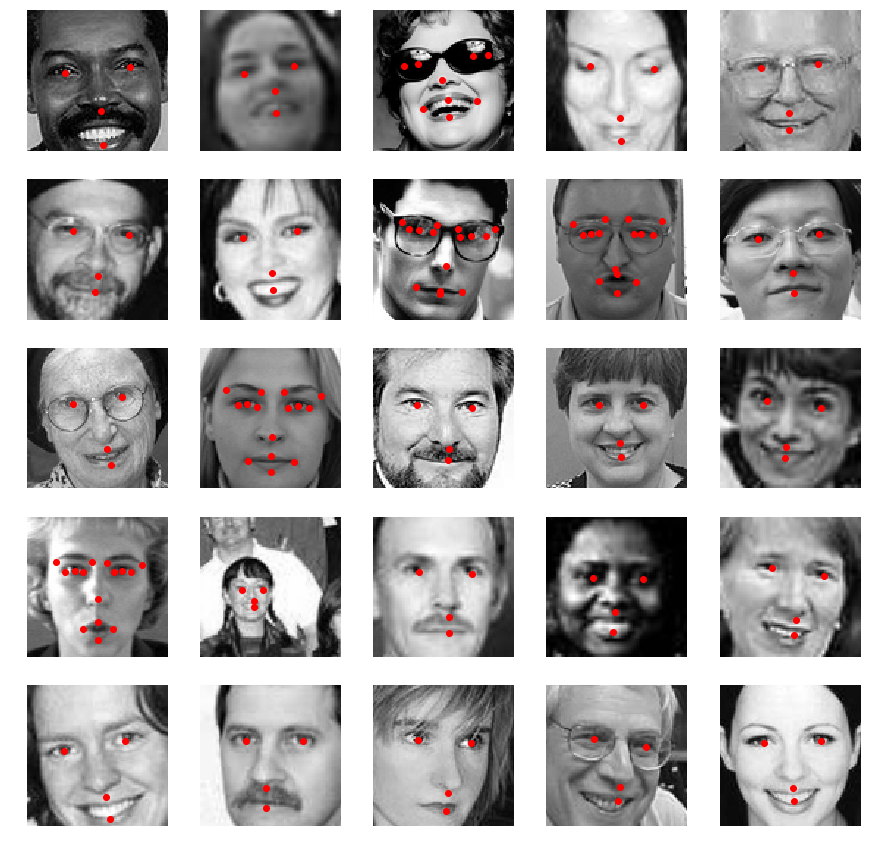

In [42]:
plot_faces_with_keypoints()

In [59]:
twoKGoodFaces = facesDF.dropna()

In [60]:
twoKGoodFaces.shape

(2140, 31)

# Building the model for 2140 "GoodFaces" with 15 data points

In [61]:
#making data and target arrays
X = np.stack([string2array(string) for string in twoKGoodFaces['Image']]).astype(np.float)[:, :, :, np.newaxis]
y = np.vstack(twoKGoodFaces[twoKGoodFaces.columns[:-1]].values)
X.shape, X.dtype

((2140, 96, 96, 1), dtype('float64'))

In [62]:
y.shape, y.dtype

((2140, 30), dtype('float64'))

In [63]:
#converting datapoints to 0 -1 values
X_train = X / 255.

In [64]:
# Creating pipeline
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

In [65]:
y_train.shape

(2140, 30)

In [80]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'ro')
        ax.axis('off')
        
    image_strings = facesDF.loc[selection]['Image']
    keypoint_cols = list(facesDF.columns)[:-1]
    keypoints = facesDF.loc[selection][keypoint_cols]

    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2array(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'go')
        ax.axis('off')
        


### Now going back to the 2140 images with all data points and using a more sophisticated modle as suggested by Peter Skvarenina here:L https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a

In [67]:
#Using a more complicated model that has been suggested for this dataset
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))


In [68]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)


Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 21s 12ms/step - loss: 0.0422 - acc: 0.2862 - val_loss: 0.0689 - val_acc: 0.0327
Epoch 2/50
1712/1712 [==============================] - 21s 12ms/step - loss: 0.0355 - acc: 0.3353 - val_loss: 0.0697 - val_acc: 0.0327
Epoch 3/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0355 - acc: 0.3353 - val_loss: 0.0704 - val_acc: 0.0327
Epoch 4/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0354 - acc: 0.3353 - val_loss: 0.0703 - val_acc: 0.0327
Epoch 5/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0354 - acc: 0.3353 - val_loss: 0.0700 - val_acc: 0.0327
Epoch 6/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0353 - acc: 0.3353 - val_loss: 0.0716 - val_acc: 0.0327
Epoch 7/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0350 - acc: 0.3329 - val_loss: 0.0718 - val_acc: 0.0327
E

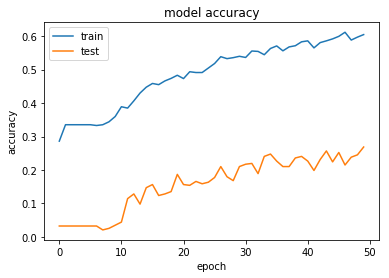

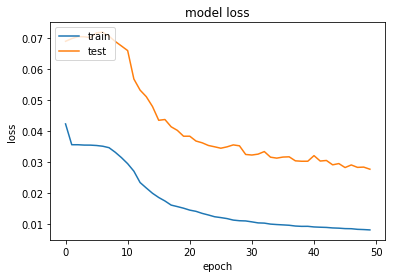

In [69]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

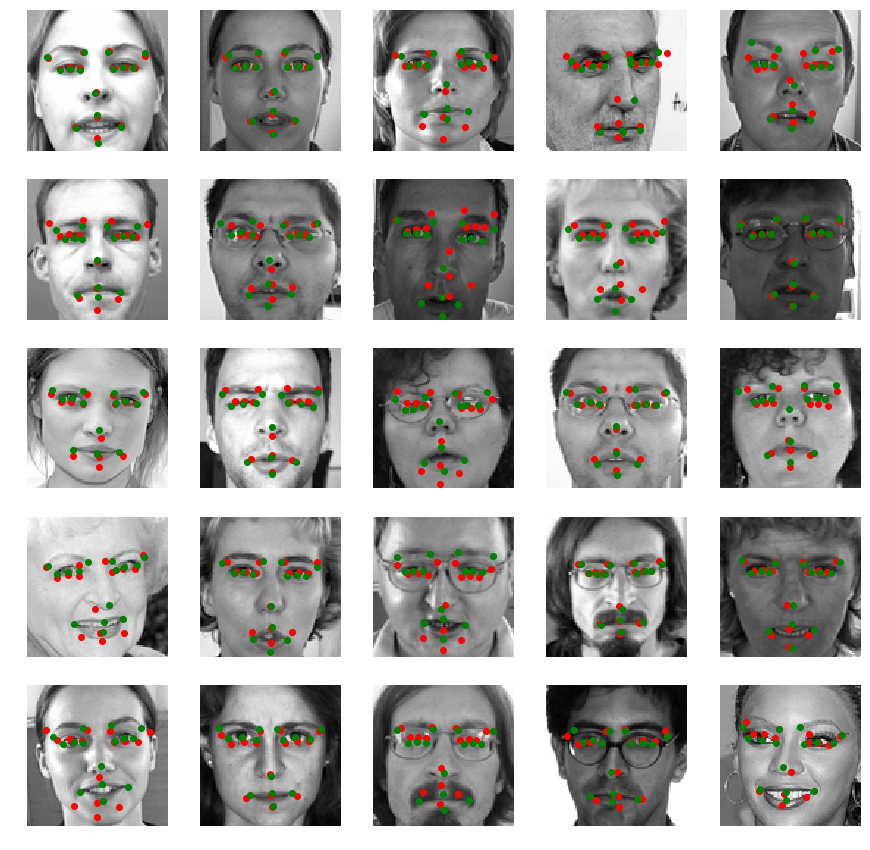

In [82]:
# calling the function above to plot the faces with the training pointss shown in green and the predicted points for hte same image shown in red
plot_faces_with_keypoints_and_predictions(model, model_input='2d')